In [1]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

In [2]:
%matplotlib notebook

In [3]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be MASTU because code assumes number of coils 
# and their locations as in MASTU() 
tokamak = freegs.machine.MASTU()

# Creates equilibrium object and initializes it with 
# a "good" solution
plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed in principle, 
                        #in practice domains as below are used to detect
                        #plasma hitting the wall during evolution
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=129, ny=129, # Number of grid points
                        psi=plasma_psi)     

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
profiles = freegs.jtor.ConstrainPaxisIp(6e3, # Plasma pressure on axis [Pascals]
                                        8e5, # Plasma current [Amps]
                                        0.5, # vacuum f = R*Bt
                                        alpha_m = 1.0,
                                        alpha_n = 2.0)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.45   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
    #if geometry is changed considerably, it can be useful to  
    #start by imposing this first set of constraints only
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           
    #then adding all of the following
           (Rx,-Zx, 1, -0.9),
           (Rx,-Zx, Rmid, -0.4),   # Outboard midplane, lower X-point
           (Rx,Zx, Rmid, +0.4),   # Outboard midplane, upper X-point
           (Rx,Zx, 1, +0.9),
           
           

           # Link inner and outer midplane locations
           (Rx, Zx, .5, 1.15),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx, -Zx, .5, -1.15),

#       # Separatrix in the divertor chamber
           (Rx,-Zx, 0.6, -1.35),
           (Rx, Zx, 0.6,  1.35),
           
           (Rx,-Zx, 0.68, -1.46),
           (Rx, Zx, 0.68,  1.46),
           
           (Rx,-Zx, 0.8, -1.62),
           (Rx, Zx, 0.8,  1.62),
           
           (Rx,-Zx, 0.95, -1.77),
           (Rx, Zx, 0.95,  1.77),
           
           (Rx,-Zx, 1.1, -1.8),
           (Rx, Zx, 1.1,  1.8),
    
           (Rx,-Zx, 1.25, -1.8),
           (Rx, Zx, 1.25,  1.8),
           
           (Rx,-Zx, 1.5, -1.7),
           (Rx, Zx, 1.5,  1.7),
           
           (Rx,-Zx, 1.8, -1.6),
           (Rx, Zx, 1.8,  1.6),
           
        # infra-coils separatrix
           (Rx,-Zx, .35, -1.3),
           (Rx, Zx, .35,  1.3),
           
           (Rx,-Zx, .5, -1.8),
           (Rx, Zx, .5,  1.8),
           
           (Rx,-Zx, .6, -1.9),
           (Rx, Zx, .6,  1.9),
    
           (Rx,-Zx, .7, -2.2),
           (Rx, Zx, .7,  2.2),
           ]

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=8e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)

<IPython.core.display.Javascript object>


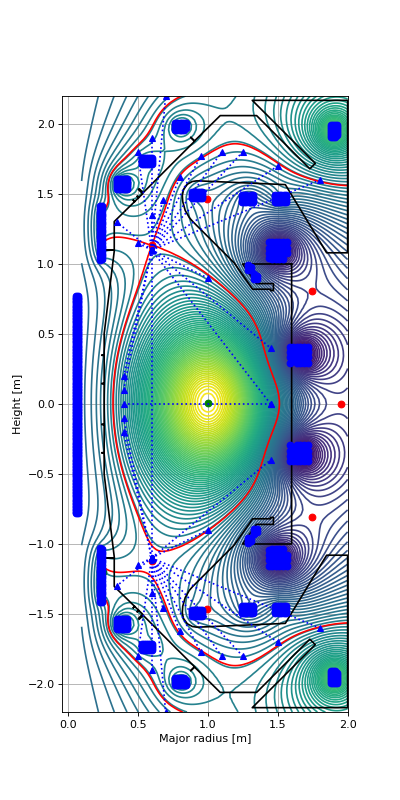

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

In [4]:
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)   # Shows results at each nonlinear iteration
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

In [5]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import evolve_plasma_NK
stepping = evolve_plasma_NK(profiles, eq)

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = np.matmul(stepping.evol_currents.R_matrix, stepping.currents_vec)[:-1]

<IPython.core.display.Javascript object>


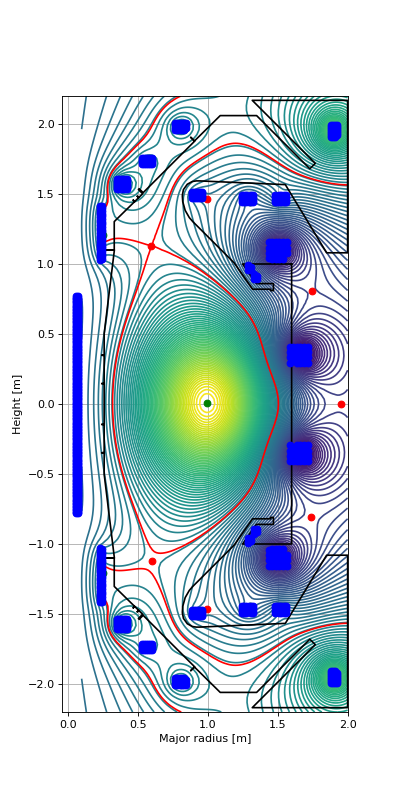

0.0006666666666666666


In [6]:
# Example of 1 timestep evolution: calculates all new currents, stores them
# and uses them to generate a new equilibrium 
# The output 'flag' signals whether the plasma hit the wall 
# Intermediate printouts are: abs and relative changes per each NK iteration
flag = stepping.do_step( U_active, # This is where the policy should go
                         currents_vec=None, # Uses the vector of currents at time t stored in 
                                            # the stepping object, i.e. from previous time step
                                            # Can be used to input something different though
                         max_rel_change=.005, # Maximum change to any currents 
                                              # used to calculate the stepsize dt for the 
                                              # implicit Euler
                         rtol=1e-3) # Accuracy required for relative change in freeGS 
                                    # NK iterations. If it is not met, it
                                    # stops iterating when the relative accuracy 
                                    # stops improving and in fact starts degrading
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
stepping.eq1.plot(axis=ax,show=False);
stepping.eq1.tokamak.plot(axis=ax,show=False);
print(stepping.dt_step) # This is the stepsize used to achieve "max_rel_change"

In [7]:
def get_O_points(eq):
    return find_critical(eq.R, eq.Z, eq.psi())[0][0]

def calculate_width(eq):
    inout = eq.innerOuterSeparatrix()
    return inout[1] - inout[0]

In [8]:
# Example of evolution with constant applied voltages
t = 0
history_times = [t]
history_currents = [stepping.new_currents]
history_o_points = [get_O_points(stepping.eq1)]
history_equilibria = [deepcopy(stepping.eq1)]
history_width = [calculate_width(stepping.eq1)]
t_per_step = []
counter = 0
max_count = 50
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    t += stepping.dt_step
    history_currents.append(stepping.new_currents)
    history_times.append(t)
    t_start = time.time()
    flag = stepping.do_step(U_active,
                 currents_vec=None, 
                 max_rel_change=.005,
                 rtol=1e-6)
    t_end = time.time()
    t_per_step.append(t_end-t_start)
    history_o_points.append(get_O_points(stepping.eq1))
    history_equilibria.append(deepcopy(stepping.eq1))
    history_width.append(calculate_width(stepping.eq1))
    counter += 1
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

'Step: 36/49'

plasma against the wall!


<IPython.core.display.Javascript object>


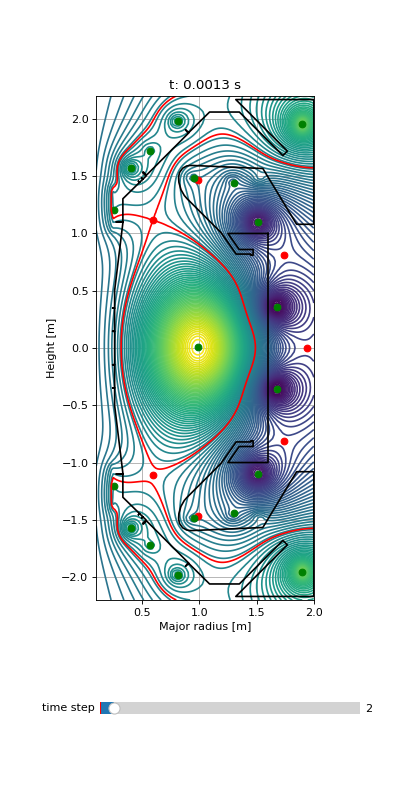

0

In [12]:
# Equilibrium evolution
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True)
fig.subplots_adjust(bottom=0.25)
history_equilibria[0].plot(axis=ax, show=False)
ax.set_title(f't: {history_times[0]:.4f} s')

ax_i = fig.add_axes([0.25, 0.1, 0.65, 0.03])
i = np.arange(0, len(history_equilibria))
s = Slider(ax_i, "time step", 0, i[-1], valinit=0, valstep=i)
def update(val):
    ax.clear()
    ax.grid(True)
    i = s.val
    history_equilibria[i].plot(axis=ax, show=False)
    ax.set_title(f't: {history_times[i]:.4f} s')
    fig.canvas.draw_dile()
s.on_changed(update)

<IPython.core.display.Javascript object>


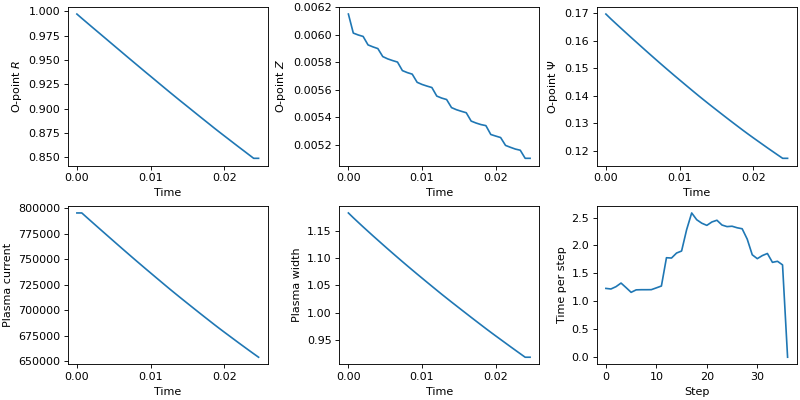

Text(0, 0.5, 'Time per step')

In [13]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0])
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1])
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2])
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1])
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width)
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(t_per_step)
axs_flat[5].set_xlabel('Step')
axs_flat[5].set_ylabel('Time per step')